In [1]:
# dependencies
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator

from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

### Data Ingestion

In [4]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
weather = weather_data._get_processed_weather('weather')
wind = weather_data._get_processed_weather('wind')
hydro = weather_data._get_processed_weather('hydro')
solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-13 23:45:00
rtm data updated up to:  13-01-2024 21:45
weather data updated.
wind data updated.
hydro data updated.
solar data updated.


### Feature Engineering

In [5]:
rtm = featured_data.shift_date(rtm, 0) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [6]:
data_for_training = featured_data._get_features(data, weather, data_type = 'dam')
featured_data._save_features(data_for_training, os.path.join(processed_data_path, 'training_data'))

### Model Building

In [15]:
data = pd.read_pickle(os.path.join(processed_data_path, 'training_data'))

In [11]:
# Set the desired cutoff dates
training_upto = data.iloc[int(data.shape[0]*0.7)]['datetime'].strftime('%Y-%m-%d')      # 70% data for training
validation_upto = data.iloc[-96]['datetime'].strftime('%Y-%m-%d')        # last day data for testing

# Split the data
X_train, y_train, X_valid, y_valid, X_test, y_test = build_model._split_data(data, training_upto, validation_upto)

In [12]:
# trail and error
n_trials = 50
n_features = 10

In [13]:
best_features, best_params = build_model._features_n_params(X_train, y_train, X_valid, y_valid, n_trials, n_features)

[I 2024-01-12 20:06:53,601] A new study created in memory with name: no-name-18a12fc6-7010-434f-86a3-f66e54b8e685
[I 2024-01-12 20:06:54,026] Trial 0 finished with value: 16.28 and parameters: {'n_estimators': 800, 'lambda_l1': 45.0, 'lambda_l2': 35.0, 'num_leaves': 8550, 'min_data_in_leaf': 4100, 'max_bin': 273, 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 13.18569532616843, 'max_depth': 9, 'learning_rate': 0.26}. Best is trial 0 with value: 16.28.


[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.400989087058971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.400989087058971
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:06:54,332] Trial 1 finished with value: 16.89 and parameters: {'n_estimators': 400, 'lambda_l1': 40.0, 'lambda_l2': 45.0, 'num_leaves': 1100, 'min_data_in_leaf': 6800, 'max_bin': 300, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 6.400989087058971, 'max_depth': 7, 'learning_rate': 0.04}. Best is trial 0 with value: 16.28.


[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9.552774266999663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.552774266999663
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:06:54,651] Trial 2 finished with value: 15.13 and parameters: {'n_estimators': 700, 'lambda_l1': 90.0, 'lambda_l2': 100.0, 'num_leaves': 7100, 'min_data_in_leaf': 2500, 'max_bin': 286, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 7, 'min_gain_to_split': 9.552774266999663, 'max_depth': 15, 'learning_rate': 0.25}. Best is trial 2 with value: 15.13.
[I 2024-01-12 20:06:54,836] Trial 3 finished with value: 16.88 and parameters: {'n_estimators': 300, 'lambda_l1': 40.0, 'lambda_l2': 15.0, 'num_leaves': 7100, 'min_data_in_leaf': 8900, 'max_bin': 271, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'min_gain_to_split': 7.4561371663264655, 'max_depth': 7, 'learning_rate': 0.21000000000000002}. Best is trial 2 with value: 15.13.


[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.4561371663264655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4561371663264655
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagg

[I 2024-01-12 20:06:54,975] Trial 4 finished with value: 24.07 and parameters: {'n_estimators': 900, 'lambda_l1': 50.0, 'lambda_l2': 30.0, 'num_leaves': 9600, 'min_data_in_leaf': 8100, 'max_bin': 300, 'feature_fraction': 0.3, 'bagging_fraction': 0.3, 'bagging_freq': 2, 'min_gain_to_split': 1.678255670964498, 'max_depth': 9, 'learning_rate': 0.17}. Best is trial 2 with value: 15.13.


[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=11.052722814932538, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.052722814932538
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-01-12 20:06:55,368] Trial 5 finished with value: 16.91 and parameters: {'n_estimators': 500, 'lambda_l1': 0.0, 'lambda_l2': 40.0, 'num_leaves': 1300, 'min_data_in_leaf': 6900, 'max_bin': 294, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 11.052722814932538, 'max_depth': 5, 'learning_rate': 0.03}. Best is trial 2 with value: 15.13.
[I 2024-01-12 20:06:55,569] Trial 6 finished with value: 15.64 and parameters: {'n_estimators': 600, 'lambda_l1': 40.0, 'lambda_l2': 45.0, 'num_leaves': 2450, 'min_data_in_leaf': 2500, 'max_bin': 233, 'feature_fraction': 0.3, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 4, 'min_gain_to_split': 1.4592674929791993, 'max_depth': 10, 'learning_rate': 0.23}. Best is trial 2 with value: 15.13.


[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.4592674929791993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592674929791993
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0
[LightGBM] [Warning] bagg

[I 2024-01-12 20:06:55,896] Trial 7 finished with value: 14.76 and parameters: {'n_estimators': 600, 'lambda_l1': 35.0, 'lambda_l2': 90.0, 'num_leaves': 7500, 'min_data_in_leaf': 400, 'max_bin': 218, 'feature_fraction': 0.8, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'min_gain_to_split': 11.832515865851787, 'max_depth': 12, 'learning_rate': 0.09999999999999999}. Best is trial 7 with value: 14.76.
[I 2024-01-12 20:06:56,056] Trial 8 finished with value: 17.2 and parameters: {'n_estimators': 500, 'lambda_l1': 55.0, 'lambda_l2': 90.0, 'num_leaves': 6350, 'min_data_in_leaf': 8200, 'max_bin': 271, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 6.896312365068329, 'max_depth': 3, 'learning_rate': 0.22}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.896312365068329, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.896312365068329
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000

[I 2024-01-12 20:06:56,597] Trial 9 finished with value: 14.76 and parameters: {'n_estimators': 700, 'lambda_l1': 70.0, 'lambda_l2': 0.0, 'num_leaves': 7450, 'min_data_in_leaf': 300, 'max_bin': 212, 'feature_fraction': 0.7, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 0.4426593496362208, 'max_depth': 13, 'learning_rate': 0.13}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=14.726913703269508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.726913703269508
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-01-12 20:06:56,931] Trial 10 finished with value: 15.21 and parameters: {'n_estimators': 100, 'lambda_l1': 10.0, 'lambda_l2': 75.0, 'num_leaves': 4000, 'min_data_in_leaf': 700, 'max_bin': 209, 'feature_fraction': 0.5, 'bagging_fraction': 0.3, 'bagging_freq': 5, 'min_gain_to_split': 14.726913703269508, 'max_depth': 12, 'learning_rate': 0.09999999999999999}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=4.569197454004766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.569197454004766
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-01-12 20:06:57,374] Trial 11 finished with value: 14.94 and parameters: {'n_estimators': 1000, 'lambda_l1': 75.0, 'lambda_l2': 0.0, 'num_leaves': 5200, 'min_data_in_leaf': 500, 'max_bin': 202, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'min_gain_to_split': 4.569197454004766, 'max_depth': 14, 'learning_rate': 0.11}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.0741554378304215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0741554378304215
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-01-12 20:06:57,673] Trial 12 finished with value: 15.27 and parameters: {'n_estimators': 700, 'lambda_l1': 70.0, 'lambda_l2': 70.0, 'num_leaves': 8600, 'min_data_in_leaf': 2100, 'max_bin': 225, 'feature_fraction': 0.7, 'bagging_fraction': 0.4, 'bagging_freq': 4, 'min_gain_to_split': 0.0741554378304215, 'max_depth': 12, 'learning_rate': 0.12}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=10.360063671578839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.360063671578839
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-01-12 20:06:58,074] Trial 13 finished with value: 15.75 and parameters: {'n_estimators': 700, 'lambda_l1': 20.0, 'lambda_l2': 65.0, 'num_leaves': 5500, 'min_data_in_leaf': 4200, 'max_bin': 226, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 10.360063671578839, 'max_depth': 13, 'learning_rate': 0.06999999999999999}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.1450378329130055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.1450378329130055
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-01-12 20:06:58,525] Trial 14 finished with value: 14.94 and parameters: {'n_estimators': 300, 'lambda_l1': 100.0, 'lambda_l2': 0.0, 'num_leaves': 8150, 'min_data_in_leaf': 200, 'max_bin': 246, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'min_gain_to_split': 4.1450378329130055, 'max_depth': 11, 'learning_rate': 0.16}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.132144983742082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.132144983742082
[LightGBM] [Warning] lambda_l2 is set=60.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-01-12 20:06:58,820] Trial 15 finished with value: 16.07 and parameters: {'n_estimators': 900, 'lambda_l1': 25.0, 'lambda_l2': 60.0, 'num_leaves': 9850, 'min_data_in_leaf': 1700, 'max_bin': 214, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'min_gain_to_split': 12.132144983742082, 'max_depth': 15, 'learning_rate': 0.3}. Best is trial 7 with value: 14.76.
[I 2024-01-12 20:06:59,071] Trial 16 finished with value: 16.79 and parameters: {'n_estimators': 600, 'lambda_l1': 65.0, 'lambda_l2': 85.0, 'num_leaves': 6750, 'min_data_in_leaf': 3700, 'max_bin': 247, 'feature_fraction': 0.8, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'min_gain_to_split': 9.14195260272384, 'max_depth': 13, 'learning_rate': 0.14}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.14195260272384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.14195260272384
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-01-12 20:06:59,315] Trial 17 finished with value: 16.69 and parameters: {'n_estimators': 800, 'lambda_l1': 80.0, 'lambda_l2': 20.0, 'num_leaves': 4500, 'min_data_in_leaf': 5800, 'max_bin': 217, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'min_gain_to_split': 4.790626626338481, 'max_depth': 11, 'learning_rate': 0.18000000000000002}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.790626626338481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.790626626338481
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000

[I 2024-01-12 20:06:59,793] Trial 18 finished with value: 15.07 and parameters: {'n_estimators': 400, 'lambda_l1': 25.0, 'lambda_l2': 55.0, 'num_leaves': 3450, 'min_data_in_leaf': 1600, 'max_bin': 200, 'feature_fraction': 0.5, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 14.707790337678272, 'max_depth': 13, 'learning_rate': 0.08}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=8.513635684734536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.513635684734536
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:00,115] Trial 19 finished with value: 16.07 and parameters: {'n_estimators': 100, 'lambda_l1': 55.0, 'lambda_l2': 15.0, 'num_leaves': 7950, 'min_data_in_leaf': 3200, 'max_bin': 234, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'min_gain_to_split': 8.513635684734536, 'max_depth': 8, 'learning_rate': 0.06999999999999999}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.8642283418143775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8642283418143775
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-01-12 20:07:00,412] Trial 20 finished with value: 15.5 and parameters: {'n_estimators': 800, 'lambda_l1': 85.0, 'lambda_l2': 100.0, 'num_leaves': 6200, 'min_data_in_leaf': 5100, 'max_bin': 258, 'feature_fraction': 0.7, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 4, 'min_gain_to_split': 2.8642283418143775, 'max_depth': 11, 'learning_rate': 0.14}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.074476957500454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.074476957500454
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-01-12 20:07:00,797] Trial 21 finished with value: 15.2 and parameters: {'n_estimators': 300, 'lambda_l1': 100.0, 'lambda_l2': 0.0, 'num_leaves': 8100, 'min_data_in_leaf': 200, 'max_bin': 246, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'min_gain_to_split': 4.074476957500454, 'max_depth': 11, 'learning_rate': 0.18000000000000002}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.4175617980232011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4175617980232011
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-01-12 20:07:01,152] Trial 22 finished with value: 16.03 and parameters: {'n_estimators': 200, 'lambda_l1': 95.0, 'lambda_l2': 5.0, 'num_leaves': 9100, 'min_data_in_leaf': 1000, 'max_bin': 257, 'feature_fraction': 0.4, 'bagging_fraction': 0.4, 'bagging_freq': 3, 'min_gain_to_split': 0.4175617980232011, 'max_depth': 14, 'learning_rate': 0.15000000000000002}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=6.100496296393741, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.100496296393741
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-01-12 20:07:01,523] Trial 23 finished with value: 14.98 and parameters: {'n_estimators': 1000, 'lambda_l1': 70.0, 'lambda_l2': 25.0, 'num_leaves': 5250, 'min_data_in_leaf': 1100, 'max_bin': 201, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'min_gain_to_split': 6.100496296393741, 'max_depth': 14, 'learning_rate': 0.09999999999999999}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=2.7696296998061967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7696296998061967
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-01-12 20:07:03,363] Trial 24 finished with value: 14.92 and parameters: {'n_estimators': 1000, 'lambda_l1': 75.0, 'lambda_l2': 10.0, 'num_leaves': 5750, 'min_data_in_leaf': 1200, 'max_bin': 208, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'min_gain_to_split': 2.7696296998061967, 'max_depth': 14, 'learning_rate': 0.01}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.3814312418589907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3814312418589907
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-01-12 20:07:04,363] Trial 25 finished with value: 15.57 and parameters: {'n_estimators': 900, 'lambda_l1': 60.0, 'lambda_l2': 10.0, 'num_leaves': 7450, 'min_data_in_leaf': 3000, 'max_bin': 220, 'feature_fraction': 0.8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 2, 'min_gain_to_split': 2.3814312418589907, 'max_depth': 15, 'learning_rate': 0.02}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=2.8279402829164795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8279402829164795
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-01-12 20:07:04,860] Trial 26 finished with value: 14.94 and parameters: {'n_estimators': 600, 'lambda_l1': 80.0, 'lambda_l2': 25.0, 'num_leaves': 6000, 'min_data_in_leaf': 1500, 'max_bin': 210, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'min_gain_to_split': 2.8279402829164795, 'max_depth': 12, 'learning_rate': 0.05}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=1.031570301986939, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.031570301986939
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:07,033] Trial 27 finished with value: 14.86 and parameters: {'n_estimators': 1000, 'lambda_l1': 30.0, 'lambda_l2': 10.0, 'num_leaves': 3000, 'min_data_in_leaf': 1000, 'max_bin': 235, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.7, 'bagging_freq': 6, 'min_gain_to_split': 1.031570301986939, 'max_depth': 13, 'learning_rate': 0.01}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.8479824490159729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8479824490159729
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:07,513] Trial 28 finished with value: 15.36 and parameters: {'n_estimators': 700, 'lambda_l1': 30.0, 'lambda_l2': 80.0, 'num_leaves': 2400, 'min_data_in_leaf': 2200, 'max_bin': 234, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.7, 'bagging_freq': 6, 'min_gain_to_split': 0.8479824490159729, 'max_depth': 10, 'learning_rate': 0.05}. Best is trial 7 with value: 14.76.
[I 2024-01-12 20:07:07,764] Trial 29 finished with value: 16.61 and parameters: {'n_estimators': 800, 'lambda_l1': 35.0, 'lambda_l2': 35.0, 'num_leaves': 3550, 'min_data_in_leaf': 4300, 'max_bin': 240, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 12.714281374295803, 'max_depth': 9, 'learning_rate': 0.12}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.714281374295803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.714281374295803
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2024-01-12 20:07:08,127] Trial 30 finished with value: 15.92 and parameters: {'n_estimators': 500, 'lambda_l1': 15.0, 'lambda_l2': 55.0, 'num_leaves': 2350, 'min_data_in_leaf': 3400, 'max_bin': 224, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'min_gain_to_split': 11.554204754294576, 'max_depth': 13, 'learning_rate': 0.08}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.7777102020970568, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7777102020970568
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:10,484] Trial 31 finished with value: 14.76 and parameters: {'n_estimators': 1000, 'lambda_l1': 50.0, 'lambda_l2': 10.0, 'num_leaves': 4700, 'min_data_in_leaf': 1100, 'max_bin': 210, 'feature_fraction': 0.8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 1.7777102020970568, 'max_depth': 14, 'learning_rate': 0.01}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.4785018737141762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4785018737141762
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:13,121] Trial 32 finished with value: 14.77 and parameters: {'n_estimators': 900, 'lambda_l1': 50.0, 'lambda_l2': 10.0, 'num_leaves': 4300, 'min_data_in_leaf': 800, 'max_bin': 217, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 1.4785018737141762, 'max_depth': 12, 'learning_rate': 0.01}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.288205521053003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.288205521053003
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:13,730] Trial 33 finished with value: 15.16 and parameters: {'n_estimators': 900, 'lambda_l1': 45.0, 'lambda_l2': 20.0, 'num_leaves': 4500, 'min_data_in_leaf': 1900, 'max_bin': 214, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 5.288205521053003, 'max_depth': 12, 'learning_rate': 0.04}. Best is trial 7 with value: 14.76.


[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.5859202805556047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5859202805556047
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:14,351] Trial 34 finished with value: 14.72 and parameters: {'n_estimators': 800, 'lambda_l1': 50.0, 'lambda_l2': 5.0, 'num_leaves': 350, 'min_data_in_leaf': 600, 'max_bin': 221, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 3.5859202805556047, 'max_depth': 10, 'learning_rate': 0.060000000000000005}. Best is trial 34 with value: 14.72.


[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.7109565369621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7109565369621
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:14,629] Trial 35 finished with value: 16.87 and parameters: {'n_estimators': 800, 'lambda_l1': 45.0, 'lambda_l2': 5.0, 'num_leaves': 750, 'min_data_in_leaf': 9800, 'max_bin': 207, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 3.7109565369621, 'max_depth': 10, 'learning_rate': 0.09}. Best is trial 34 with value: 14.72.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.469692881292385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.469692881292385
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:15,222] Trial 36 finished with value: 14.41 and parameters: {'n_estimators': 700, 'lambda_l1': 60.0, 'lambda_l2': 30.0, 'num_leaves': 7050, 'min_data_in_leaf': 200, 'max_bin': 229, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 13.469692881292385, 'max_depth': 8, 'learning_rate': 0.060000000000000005}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.682257087164539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.682257087164539
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:15,663] Trial 37 finished with value: 15.88 and parameters: {'n_estimators': 600, 'lambda_l1': 60.0, 'lambda_l2': 35.0, 'num_leaves': 200, 'min_data_in_leaf': 2700, 'max_bin': 228, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 13.682257087164539, 'max_depth': 7, 'learning_rate': 0.060000000000000005}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.656797679739503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.656797679739503
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:16,322] Trial 38 finished with value: 15.06 and parameters: {'n_estimators': 800, 'lambda_l1': 40.0, 'lambda_l2': 45.0, 'num_leaves': 1750, 'min_data_in_leaf': 1400, 'max_bin': 220, 'feature_fraction': 1.0, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 13.656797679739503, 'max_depth': 8, 'learning_rate': 0.03}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.463571256138906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.463571256138906
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:16,939] Trial 39 finished with value: 15.39 and parameters: {'n_estimators': 700, 'lambda_l1': 55.0, 'lambda_l2': 30.0, 'num_leaves': 9100, 'min_data_in_leaf': 2400, 'max_bin': 222, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 10.463571256138906, 'max_depth': 6, 'learning_rate': 0.03}. Best is trial 36 with value: 14.41.
[I 2024-01-12 20:07:17,175] Trial 40 finished with value: 16.77 and parameters: {'n_estimators': 700, 'lambda_l1': 65.0, 'lambda_l2': 20.0, 'num_leaves': 6850, 'min_data_in_leaf': 6400, 'max_bin': 229, 'feature_fraction': 1.0, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 2.234808592178866, 'max_depth': 5, 'learning_rate': 0.2}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.234808592178866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.234808592178866
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] baggin

[I 2024-01-12 20:07:17,792] Trial 41 finished with value: 14.55 and parameters: {'n_estimators': 600, 'lambda_l1': 50.0, 'lambda_l2': 5.0, 'num_leaves': 7550, 'min_data_in_leaf': 400, 'max_bin': 213, 'feature_fraction': 0.8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 7.731400434955526, 'max_depth': 9, 'learning_rate': 0.060000000000000005}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.839484641149396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839484641149396
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:18,538] Trial 42 finished with value: 14.47 and parameters: {'n_estimators': 500, 'lambda_l1': 50.0, 'lambda_l2': 5.0, 'num_leaves': 7550, 'min_data_in_leaf': 200, 'max_bin': 212, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 7.839484641149396, 'max_depth': 9, 'learning_rate': 0.060000000000000005}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.7612987592485965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.7612987592485965
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:19,036] Trial 43 finished with value: 14.56 and parameters: {'n_estimators': 500, 'lambda_l1': 60.0, 'lambda_l2': 5.0, 'num_leaves': 7550, 'min_data_in_leaf': 200, 'max_bin': 206, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 7, 'min_gain_to_split': 7.7612987592485965, 'max_depth': 8, 'learning_rate': 0.060000000000000005}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.8818095423941035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.8818095423941035
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-01-12 20:07:19,565] Trial 44 finished with value: 14.78 and parameters: {'n_estimators': 400, 'lambda_l1': 50.0, 'lambda_l2': 5.0, 'num_leaves': 8500, 'min_data_in_leaf': 500, 'max_bin': 204, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 7, 'min_gain_to_split': 7.8818095423941035, 'max_depth': 9, 'learning_rate': 0.05}. Best is trial 36 with value: 14.41.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=6.995943943822555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.995943943822555
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:20,017] Trial 45 finished with value: 14.39 and parameters: {'n_estimators': 500, 'lambda_l1': 60.0, 'lambda_l2': 15.0, 'num_leaves': 6550, 'min_data_in_leaf': 200, 'max_bin': 206, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'min_gain_to_split': 6.995943943822555, 'max_depth': 8, 'learning_rate': 0.06999999999999999}. Best is trial 45 with value: 14.39.


[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=6.80630944918764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.80630944918764
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:20,426] Trial 46 finished with value: 14.34 and parameters: {'n_estimators': 500, 'lambda_l1': 60.0, 'lambda_l2': 15.0, 'num_leaves': 6700, 'min_data_in_leaf': 300, 'max_bin': 206, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'min_gain_to_split': 6.80630944918764, 'max_depth': 8, 'learning_rate': 0.08}. Best is trial 46 with value: 14.34.


[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=6.604660546306302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.604660546306302
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:20,765] Trial 47 finished with value: 14.86 and parameters: {'n_estimators': 500, 'lambda_l1': 65.0, 'lambda_l2': 15.0, 'num_leaves': 6550, 'min_data_in_leaf': 800, 'max_bin': 212, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'min_gain_to_split': 6.604660546306302, 'max_depth': 7, 'learning_rate': 0.09}. Best is trial 46 with value: 14.34.


[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=5.912584784133258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.912584784133258
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:21,130] Trial 48 finished with value: 15.09 and parameters: {'n_estimators': 400, 'lambda_l1': 55.0, 'lambda_l2': 25.0, 'num_leaves': 7100, 'min_data_in_leaf': 1400, 'max_bin': 281, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'min_gain_to_split': 5.912584784133258, 'max_depth': 8, 'learning_rate': 0.08}. Best is trial 46 with value: 14.34.


[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.043566721941651, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.043566721941651
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-01-12 20:07:21,416] Trial 49 finished with value: 14.92 and parameters: {'n_estimators': 500, 'lambda_l1': 45.0, 'lambda_l2': 30.0, 'num_leaves': 7800, 'min_data_in_leaf': 1900, 'max_bin': 215, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'min_gain_to_split': 7.043566721941651, 'max_depth': 6, 'learning_rate': 0.11}. Best is trial 46 with value: 14.34.




Best MAPE achieved:  14.34


### Model Training

In [11]:
# training upto this date
training_upto = data[::96]['datetime'].iloc[-1].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(data, training_upto, validation_upto)

In [12]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression', model_type = 'dam_forecast')

[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=14.981109788759145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.981109788759145
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [13]:
lower_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', model_type = 'dam_lower', alpha = 0.1)

In [14]:
upper_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', model_type = 'dam_upper', alpha = 0.9)

### Model Evaluation

In [20]:
evaluator = ModelEvaluator(model, best_features)

Evaluating on train data:
MAPE: 11.75


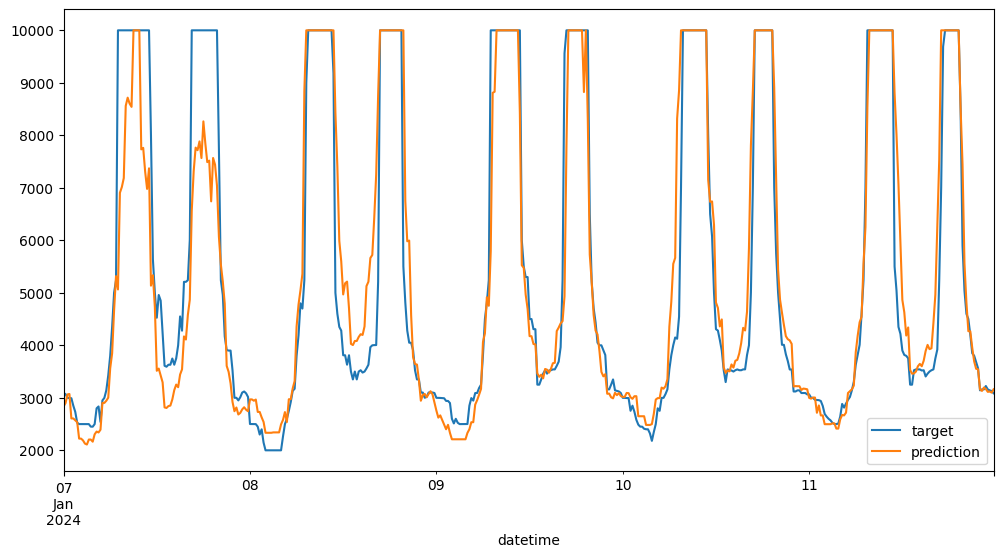

In [22]:
evaluator.evaluate_on_data(X_train, y_train, 'train', 5)

Evaluating on test data:
MAPE: 5.6899999999999995


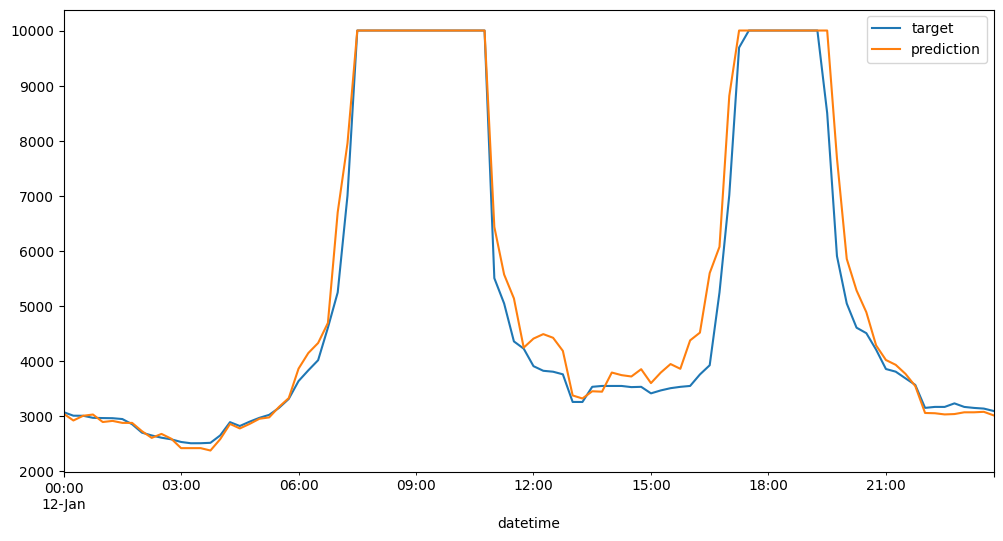

In [25]:
evaluator.evaluate_on_data(X_test, y_test, 'test', 5)